In [32]:
!pip install -Uqq fastai duckduckgo_search

# DDG API documentation
# https://pypi.org/project/duckduckgo-search/#3-images---image-search-by-duckduckgocom
from fastcore.all import *
from duckduckgo_search import ddg_images
from fastdownload import download_url
from fastai.vision.all import *
from duckduckgo_search import DDGS
import os

In [33]:
# helpful functions to DRY

# need to make sure this is closed later on
def search_ddg(search_terms):
    ddgs = DDGS()
    return ddgs.images(
        keywords = search_terms,
        region="wt-wt",
        safesearch="moderate",
        type_image="photo",
    )

In [34]:
categories = 'dolphin', 'manatee', 'turtle', 'whale'
generators = {}
for category in categories:
    generators[category] = search_ddg(category)
    
print(next(generators['dolphin']))
print(next(generators['manatee']))
print(next(generators['whale']))
print(next(generators['turtle']))

{'title': 'Dolphin 4k Ultra HD Wallpaper', 'image': 'https://images.alphacoders.com/293/293531.jpg', 'thumbnail': 'https://tse2.mm.bing.net/th?id=OIP.iEJ06_DV_5PHBbDWIZ6ZqQHaF1&pid=Api', 'url': 'https://wall.alphacoders.com/big.php?i=293531', 'height': 3781, 'width': 4800, 'source': 'Bing'}
{'title': 'Manatees were once important Seminole food source • The Seminole Tribune', 'image': 'http://seminoletribune.org/wp-content/uploads/2019/04/Manatee-1.jpg', 'thumbnail': 'https://tse1.mm.bing.net/th?id=OIP.x31nae0GHXce_eSC5-KnIAHaE8&pid=Api', 'url': 'https://seminoletribune.org/manatees-were-once-important-seminole-food-source/', 'height': 1600, 'width': 2400, 'source': 'Bing'}
{'title': 'Fascinating Humpback Whale Facts', 'image': 'https://fthmb.tqn.com/l1vhEscfQQUiCi9W8ZpJ79vc144=/5200x3313/filters:fill(auto,1)/humpback-whale-underwater-portrait--107312834-5a01c2cab39d03001952917f.jpg', 'thumbnail': 'https://tse3.mm.bing.net/th?id=OIP.ex5KYElGdSup7eoO0fMIwQHaEt&pid=Api', 'url': 'https://w

Just for fun, download a few images

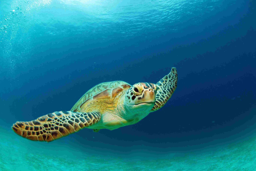

In [35]:
for animal in categories:
    gen = generators[animal]
    name = animal + '.jpg'
    download_url(next(gen)['image'], name, show_progress=False)
    Image.open(name).to_thumb(256,256)

Image.open('turtle.jpg').to_thumb(256,256)

In [36]:
def get_n_urls (generator, n):
    items=[]
    for i in range(n):
        try:
            items.append(next(generator)['image'])
        except StopIteration:
            break
    return items

## *WARNING* - If you have bad data and want to replace it you may need to delete the files. New files are not downloaded if the folder has >=50. Or you could change the value of images_per_folder

This is not perfect as the ddg_search sometimes returns less than the number of items requested. But it will prevent wasting time downloading pictures to an extent.

In [37]:
images_per_folder = 50 # how many images each search downloads

path = Path('lesson1/training_images')

for category in categories:
    dest = (path/category)
    dest.mkdir(exist_ok=True, parents=true)
    if len(os.listdir(str(dest))) < images_per_folder:
        print(f"downloading {category}")
        gen = generators[category]
        download_images(dest, urls=get_n_urls(gen, images_per_folder))
        resize_images(path/category, max_size=400, dest=path/category)

downloading manatee


In [38]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

23

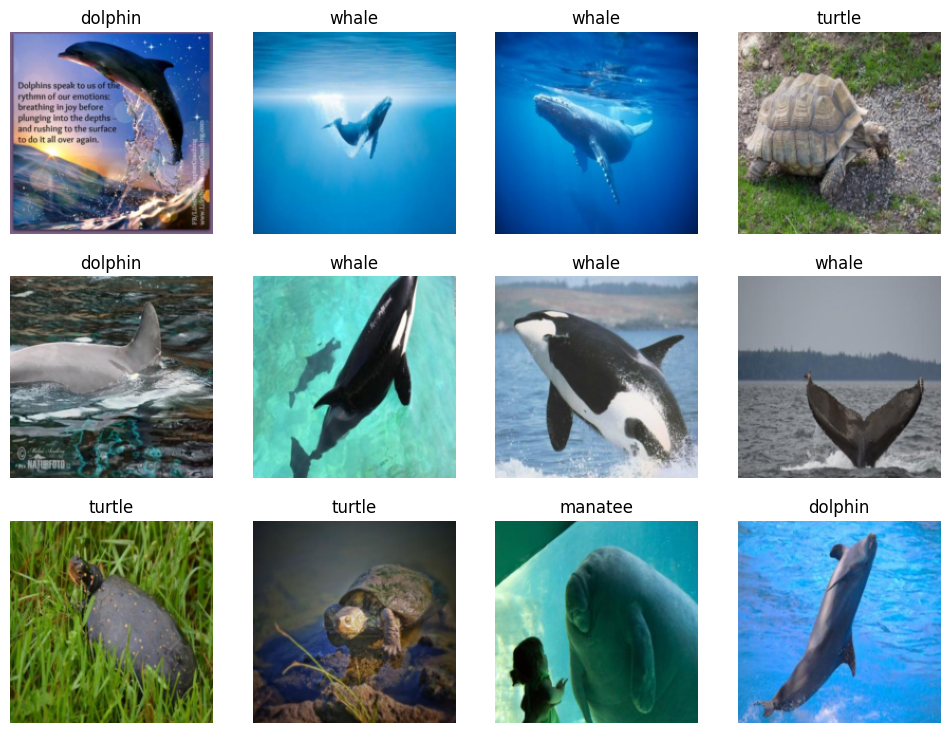

In [39]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=12)

In [40]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

/home/jared/Programming/fastai/venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jared/Programming/fastai/venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Now we download data that should not match the model. After that we will run predictions

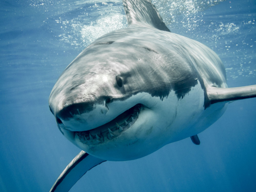

In [41]:
# Should not match at all
dogs = search_ddg('dog')
dog = next(dogs)
download_url(dog['image'], 'dog.jpg', show_progress=False)
Image.open('dog.jpg').to_thumb(256, 256)

# Might match or partially match the model vs dolphins or whales
sharks = search_ddg('shark')
shark = next(sharks)
download_url(shark['image'], 'shark.jpg', show_progress=False)
Image.open('shark.jpg').to_thumb(256,256)

Now we compare our images vs the model and see what it predicts.

In [42]:
#TODO - through this in the cloud and see if it' sbetter
#TODO - use these critters in his code
#TODO use animals that aren't in the sea. BIgger differences
is_dolphin,_,probs = learn.predict(PILImage.create('dolphin.jpg'))
print(f"This is a: {dolphin}.")
print(f"Probability it's a dolphin: {probs[0]:.4f}")

is_whale,_,probs = learn.predict(PILImage.create('whale.jpg'))
print(f"This is a: {whale}.")
print(f"Probability it's a whale: {probs[0]:.4f}")

is_turtle,_,probs = learn.predict(PILImage.create('turtle.jpg'))
print(f"This is a: {turtle}.")
print(f"Probability it's a turtle: {probs[0]:.4f}")

is_manatee,_,probs = learn.predict(PILImage.create('manatee.jpg'))
print(f"This is a: {manatee}.")
print(f"Probability it's a manatee: {probs[0]:.4f}")

NameError: name 'dolphin' is not defined

Lastly, we need to close all the generators used. It would have been better to put all the generators in an array so they could be iterated through, but this is fine. I'm focusing on ML over Python.